In [209]:
# import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always')

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
df=pd.read_csv('training_100.csv')
df['timestamp']=pd.to_datetime(df['timestamp'])
df.head() 
df.tail()

timestamp  kpi_value  request_count  anomaly_label
20154 2020-08-28 01:56:00+02:00   0.998149          26467              0
20155 2020-08-28 01:57:00+02:00   0.998340          26502              0
20156 2020-08-28 01:58:00+02:00   0.998364          26887              0
20157 2020-08-28 01:59:00+02:00   0.998428          26712              0
20158 2020-08-28 02:00:00+02:00   0.997407          29694              0

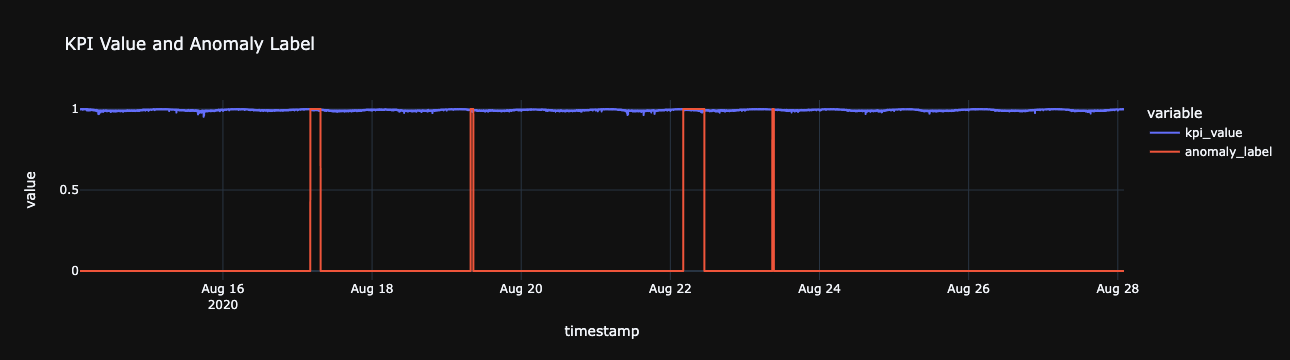

In [210]:
import plotly.express as px
fig = px.line(df, x="timestamp", y=['kpi_value', 'anomaly_label'], title='KPI Value and Anomaly Label', template='plotly_dark')
fig.show()

In [211]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2020-08-14 02:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-28 02:00:00+0200', tz='pytz.FixedOffset(120)'))

In [212]:
percent_test=70
percent_test=percent_test/100

time=df['timestamp']
time_point=time[round(len(df)*percent_test)]
time_point

Timestamp('2020-08-23 21:11:00+0200', tz='pytz.FixedOffset(120)')

In [213]:
train, test = df.loc[df['timestamp'] <= time_point], df.loc[df['timestamp'] > time_point]
train.shape, test.shape

((14112, 4), (6047, 4))

In [214]:
scaler = StandardScaler()
scaler = scaler.fit(train[['kpi_value']])

#train['kpi_value'] = scaler.transform(train[['kpi_value']])
#test['kpi_value'] = scaler.transform(test[['kpi_value']])

In [215]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps): #Should reach max-time_step since anything after that would not predict correctly. Final iteration train from [len(X)-time_steps] until [len(X)-1], then use len(X) to predict the last value
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['kpi_value']], train['kpi_value'])
X_test, y_test = create_sequences(test[['kpi_value']], test['kpi_value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (14082, 30, 1)
Testing shape: (6017, 30, 1)


In [216]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(30, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 50)            10400     
                                                                 
 lstm_25 (LSTM)              (None, 64)                29440     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [217]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
397/397 [==============================] - 10s 20ms/step - loss: 0.0099 - val_loss: 2.9748e-06
Epoch 2/100
397/397 [==============================] - 7s 18ms/step - loss: 4.5492e-06 - val_loss: 3.4559e-06
Epoch 3/100
397/397 [==============================] - 7s 18ms/step - loss: 4.8476e-06 - val_loss: 4.7242e-06
Epoch 4/100
397/397 [==============================] - 7s 18ms/step - loss: 4.7363e-06 - val_loss: 7.8105e-06


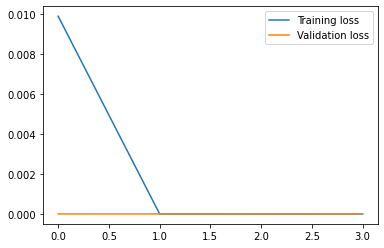

In [218]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [219]:
model.evaluate(X_test, y_test)

189/189 [==============================] - 1s 5ms/step - loss: 6.5247e-06


6.524666787299793e-06

Train Prediction Shape: (14082, 1)
y Train Shape: (14082,)
Reconstruction error threshold: 0.013110944399137606


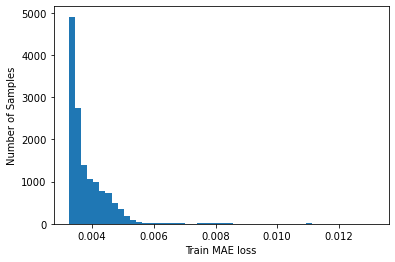

In [220]:
train_prediction = model.predict(X_train, verbose=0)
print(f"Train Prediction Shape: {train_prediction.shape}")
print(f"y Train Shape: {y_train.shape}")
train_mae_loss = np.mean(np.abs(train_prediction - y_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Test Prediction Shape: (6017, 1)
y Test Shape: (6017,)
Reconstruction error threshold: 0.005779189530951353


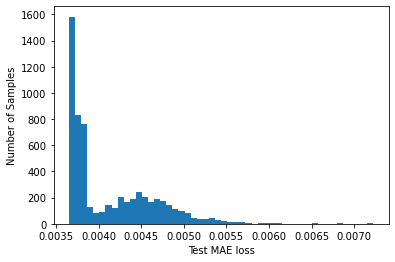

In [221]:
test_prediction = model.predict(X_test, verbose=0)
print(f"Test Prediction Shape: {test_prediction.shape}")
print(f"y Test Shape: {y_test.shape}")
test_mae_loss = np.mean(np.abs(test_prediction - y_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples');

threshold = 0.8*np.max(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

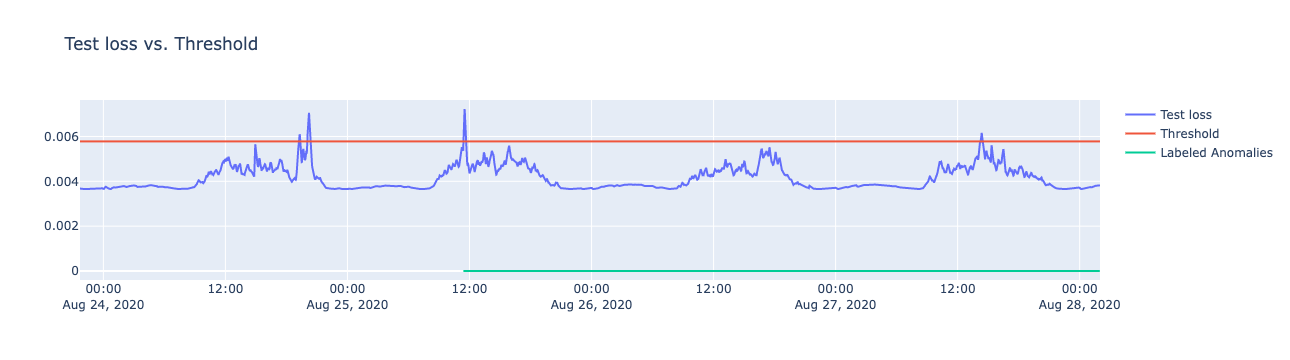

In [222]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['kpi_value'] = test[TIME_STEPS:]['kpi_value']
y_pred=model.predict(X_test)
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.add_trace(go.Scatter(x=df['timestamp'][16404:20158], y=df['anomaly_label'], name='Labeled Anomalies'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [223]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(51, 7)

In [224]:
anomalies

timestamp  kpi_value  request_count  anomaly_label  \
15434 2020-08-24 19:14:00+02:00   0.983239           8830              0   
15435 2020-08-24 19:15:00+02:00   0.987728           8882              0   
15436 2020-08-24 19:16:00+02:00   0.985319           8923              0   
15437 2020-08-24 19:17:00+02:00   0.984587           8759              0   
15438 2020-08-24 19:18:00+02:00   0.989783           8809              0   
15439 2020-08-24 19:19:00+02:00   0.990291           8549              0   
15440 2020-08-24 19:20:00+02:00   0.991176           8953              0   
15441 2020-08-24 19:21:00+02:00   0.989070           8783              0   
15484 2020-08-24 20:04:00+02:00   0.982467           8099              0   
15485 2020-08-24 20:05:00+02:00   0.988600           8158              0   
15486 2020-08-24 20:06:00+02:00   0.981008           8372              0   
15487 2020-08-24 20:07:00+02:00   0.987943           8626              0   
15488 2020-08-24 20:08:00+02:00   0.981186           8345              0   
15489 2020-08-24 20:09:00+02:00   0.982241           8221              0   
15490 2020-08-24 20:10:00+02:00   0.984975           8386              0   
15491 2020-08-24 20:11:00+02:00   0.982151           8404              0   
15492 2020-08-24 20:12:00+02:00   0.988062           8209              0   
15493 2020-08-24 20:13:00+02:00   0.988599           8157              0   
15494 2020-08-24 20:14:00+02:00   0.989242           8552              0   
15495 2020-08-24 20:15:00+02:00   0.988491           8515              0   
15496 2020-08-24 20:16:00+02:00   0.985585           8394              0   
15497 2020-08-24 20:17:00+02:00   0.985433           8238              0   
15498 2020-08-24 20:18:00+02:00   0.989012           8646              0   
15499 2020-08-24 20:19:00+02:00   0.987290           8497              0   
15500 2020-08-24 20:20:00+02:00   0.987004           8926              0   
15501 2020-08-24 20:21:00+02:00   0.989215           8623              0   
15502 2020-08-24 20:22:00+02:00   0.989579           8636              0   
15503 2020-08-24 20:23:00+02:00   0.990291           7931              0   
16405 2020-08-25 11:25:00+02:00   0.985652           8921              0   
16406 2020-08-25 11:26:00+02:00   0.972677           8857              0   
16407 2020-08-25 11:27:00+02:00   0.986035           9094              0   
16408 2020-08-25 11:28:00+02:00   0.987125           8932              0   
16409 2020-08-25 11:29:00+02:00   0.978441           8813              0   
16410 2020-08-25 11:30:00+02:00   0.988650           9427              0   
16411 2020-08-25 11:31:00+02:00   0.988913           9561              0   
16412 2020-08-25 11:32:00+02:00   0.989338           9379              0   
16413 2020-08-25 11:33:00+02:00   0.989510           9438              0   
16414 2020-08-25 11:34:00+02:00   0.989415           9258              0   
16415 2020-08-25 11:35:00+02:00   0.988754           9070              0   
16416 2020-08-25 11:36:00+02:00   0.989243           9203              0   
16417 2020-08-25 11:37:00+02:00   0.990002           9102              0   
16418 2020-08-25 11:38:00+02:00   0.986860           8828              0   
19456 2020-08-27 14:18:00+02:00   0.987566           6836              0   
19457 2020-08-27 14:19:00+02:00   0.985544           6779              0   
19458 2020-08-27 14:20:00+02:00   0.983204           7204              0   
19459 2020-08-27 14:21:00+02:00   0.987739           7177              0   
19460 2020-08-27 14:22:00+02:00   0.988806           7415              0   
19461 2020-08-27 14:23:00+02:00   0.989696           7182              0   
19462 2020-08-27 14:24:00+02:00   0.987392           7376              0   
19463 2020-08-27 14:25:00+02:00   0.987261           7379              0   
19464 2020-08-27 14:26:00+02:00   0.989468           7216              0   

           loss  threshold  anomaly  
15434  0.005782   0.005779     

In [225]:
anomalies["anomaly"]

15434    True
15435    True
15436    True
15437    True
15438    True
15439    True
15440    True
15441    True
15484    True
15485    True
15486    True
15487    True
15488    True
15489    True
15490    True
15491    True
15492    True
15493    True
15494    True
15495    True
15496    True
15497    True
15498    True
15499    True
15500    True
15501    True
15502    True
15503    True
16405    True
16406    True
16407    True
16408    True
16409    True
16410    True
16411    True
16412    True
16413    True
16414    True
16415    True
16416    True
16417    True
16418    True
19456    True
19457    True
19458    True
19459    True
19460    True
19461    True
19462    True
19463    True
19464    True
Name: anomaly, dtype: bool

In [226]:
test_score_df['kpi_value']

14142    0.994653
14143    0.996258
14144    0.993949
14145    0.994913
14146    0.994694
           ...   
20154    0.998149
20155    0.998340
20156    0.998364
20157    0.998428
20158    0.997407
Name: kpi_value, Length: 6017, dtype: float64

In [227]:
test_score_df['kpi_value'].values.reshape(-1,1)

array([[0.99465293],
       [0.99625837],
       [0.99394945],
       ...,
       [0.99836352],
       [0.99842767],
       [0.99740688]])

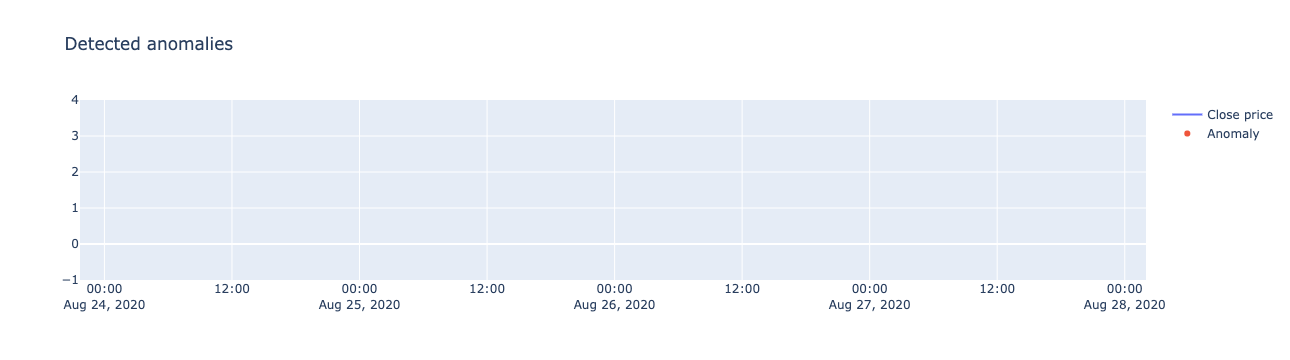

In [228]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=scaler.inverse_transform(test_score_df['kpi_value'].values.reshape(1,-1)), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(anomalies['kpi_value'].values.reshape(1,-1)), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [229]:
loss=test_score_df['loss']
loss
threshold=test_score_df['threshold']
threshold.iloc[8]

0.005779189530951353

In [230]:
n=0
a=0

new_anomalies=[]

for i in range(len(test_score_df['loss'])):
    if test_score_df['loss'].iloc[i] <= test_score_df['threshold'].iloc[i]:
        n=n+1
        t=0
        new_anomalies.append(t)
    elif test_score_df['loss'].iloc[i] > test_score_df['threshold'].iloc[i]:
        a=a+1
        t=1
        new_anomalies.append(t)

        

        
print(f"Number of no anomalies: {n}")
print(f"Number of anomalies: {a}")

Number of no anomalies: 5966
Number of anomalies: 51


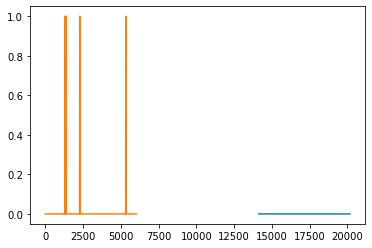

In [231]:
label=test_score_df['anomaly_label']
len(label)-len(new_anomalies)
plt.plot(label)
plt.plot(new_anomalies)

<AxesSubplot:>

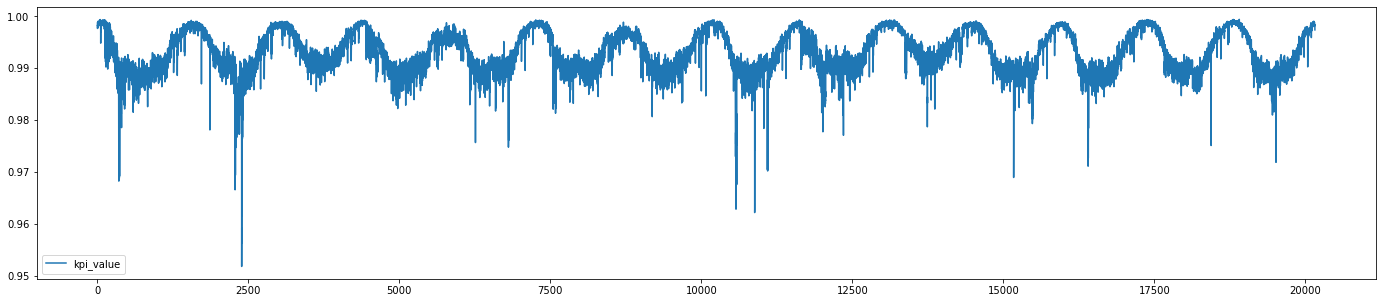

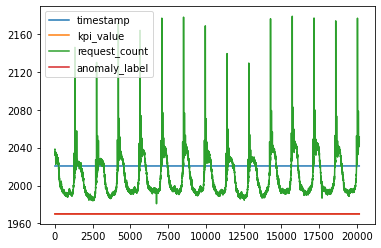

In [232]:
df['kpi_value'].plot(figsize = (24, 5), legend = True)
df.plot(legend = True)

In [233]:
label=df['anomaly_label']
print(len(label))
import math

20159


In [234]:
test['kpi_value']

14112    0.994147
14113    0.995845
14114    0.994527
14115    0.992936
14116    0.993641
           ...   
20154    0.998149
20155    0.998340
20156    0.998364
20157    0.998428
20158    0.997407
Name: kpi_value, Length: 6047, dtype: float64

In [235]:
y_pred

array([[0.99213624],
       [0.99216765],
       [0.99223405],
       ...,
       [0.99484706],
       [0.994832  ],
       [0.99482065]], dtype=float32)

In [236]:
print(f"Test Length: {len(test['kpi_value'])}")
print(f"Y Prediction Length: {len(y_pred)}")

Test Length: 6047
Y Prediction Length: 6017


In [237]:
label=test_score_df['anomaly_label']
label.shape

(6017,)

In [238]:
len(new_anomalies)

6017

In [239]:
label.iloc[0]

0

In [240]:
new_anomalies[0]

0

In [241]:
tp60m=0
fp60m=0
tn60m=0
fn60m=0
for i in range((len(label))):
    if new_anomalies[i] == 1 and label.iloc[i] == 1:
            tp60m=tp60m+1
    elif new_anomalies[i] == 1 and label.iloc[i] == 0:
            fp60m=fp60m+1
    elif new_anomalies[i] == 0 and label.iloc[i] == 1:
            fn60m=fn60m+1
    elif new_anomalies[i] == 0 and label.iloc[i] == 0:
            tn60m=tn60m+1

In [242]:
print("THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE")
print("###################################################################################")
print(f"Number of True Positives: {tp60m}")
print(f"Number of False Positives: {fp60m}")
print(f"Number of True Negatives: {tn60m}")
print(f"Number of False Negatives: {fn60m}")
print("###################################")

precision_60m=tp60m/(tp60m+fp60m)
print(f"Precision: {round(precision_60m,3)}")

recall_60m=tp60m/(tp60m+fn60m)
print(f"Recall: {round(recall_60m,3)}")

F1_Score_60m=(2*precision_60m*recall_60m)/(precision_60m+recall_60m)
print(f"F1 Score: {round(F1_Score_60m,3)}")

THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE
###################################################################################
Number of True Positives: 0
Number of False Positives: 51
Number of True Negatives: 5966
Number of False Negatives: 0
###################################
Precision: 0.0


ZeroDivisionError: division by zero

In [244]:
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

precision_60_2=precision_score(new_anomalies,label, average='macro')
print(f"Precision Using Sklearn: {round(precision_60_2,3)}")

average_precision_60_2=average_precision_score(new_anomalies,label, average='macro')
print(f"Average Precision Using Sklearn: {round(average_precision_60_2,3)}")

recall_60_2=recall_score(new_anomalies,label, average='macro')
print(f"Recall Using Sklearn: {round(recall_60_2,3)}")

F1_Score_2=f1_score(new_anomalies,label, average='macro')
print(f"F1 Score Using Sklearn: {round(F1_Score_2,3)}")

Precision Using Sklearn: 0.496
Average Precision Using Sklearn: 0.008
Recall Using Sklearn: 0.5
F1 Score Using Sklearn: 0.498


/Users/khalidalnahyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

